# 5. Timing analysis

We will produce a light curve of Mrk 421 in two energy bands, compute the ratio of the fluxes and see if there is any hint of spectral variability.

For this tutorial, we will need a few extra python packages (such as `astroquery` to query Virtual Observatory services).

In [1]:
# !mamba install -c conda-forge astroquery
#
# or:
#
# !mamba create -n cads-2024 -c conda-forge gammapy=1.2 ipykernel astroquery tqdm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time
from astroquery.simbad import Simbad

import scipy


from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.estimators.utils import (
    compute_lightcurve_fvar,
    compute_lightcurve_fpp,
    compute_lightcurve_doublingtime,
    get_rebinned_axis,
    resample_energy_edges,
)
from gammapy.makers import (
    DatasetsMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.makers.utils import make_theta_squared_table
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
)
from gammapy.utils import pbar
pbar.SHOW_PROGRESS_BAR = True
from gammapy.visualization import plot_spectrum_datasets_off_regions, plot_theta_squared_table

from regions import CircleSkyRegion

from IPython.display import display

/home/jlenain/local/opt/mambaforge/envs/cads-2024/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We first load the relevant data set:

In [3]:
data_store = DataStore.from_dir(
    f"$GAMMAPY_DATA/hess-dl3-dr1"
)

We set the properties of the source of interest. Bonus: we can use Virtual Observatory services to query the source parameters.

In [4]:
src = dict()
# src['Name'] = 'Mrk 421'
src['Name'] = 'PKS 2155-304'
src['Position'] = SkyCoord.from_name(src['Name'])

try:
    simbad = Simbad()
    simbad.add_votable_fields("z_value")
    query = simbad.query_object(src['Name'])
    src['Redshift'] = query["Z_VALUE"].data[0]
except NameError:
    src['Redshift'] = 0.030

We select a sub-sample of data acquired on our source:

In [5]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=src['Position'].ra,
    lat=src['Position'].dec,
    radius="3 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

selection = dict(
type="time_box",
time_range=Time(["2006-07-29T12:00", "2006-07-30T12:00"]),
)
selected_obs_table = selected_obs_table.select_observations(selection)
obs_ids = selected_obs_table["OBS_ID"]
observations = data_store.get_observations(obs_ids)

Obs Id: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 838.95it/s]


Let's create a time intervals, for later use, and filter the observations on it:

In [6]:
t0 = observations[0].tstart
duration = 15 * u.min
n_time_bins = int((observations[-1].tstop-t0)/duration)+1
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])]
time_intervals

short_observations = observations.select_time(time_intervals)

In [7]:
# Or just observation byobservation
#time_intervals = [Time([obs.tstart, obs.tstop]) for obs in observations]
#short_observations = observations

# Data reduction

Let's perform a 1D analysis of the data.

In [8]:
on_region_radius = Angle("0.1 deg")

on_region = CircleSkyRegion(center=src['Position'], radius=on_region_radius)
exclusion_region = CircleSkyRegion(center=src['Position'],radius=0.5 * u.deg)
geom = WcsGeom.create(
    npix=(120, 120), binsz=0.05, skydir=src['Position'], proj="TAN", frame="icrs"
)
exclusion_mask = ~geom.region_mask([exclusion_region])

In [9]:
energy_axis = MapAxis.from_energy_bounds(0.02, 200, nbin=5, per_decade=True, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(0.005, 300, nbin=10, per_decade=True, unit="TeV", name="energy_true")

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "edisp"])

bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [10]:
%%time

datasets = Datasets()

for obs in short_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)

    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

CPU times: user 19.1 s, sys: 157 ms, total: 19.2 s
Wall time: 19.2 s


In [11]:
dataset_stack = datasets.stack_reduce()

Let's find the some energy to slice our data, to build two well-balanced sets into two energy bands:

In [13]:
excess = dataset_stack.excess.data.T[0][0]
mask = excess > 0
excess = excess[mask]
energy_bins = dataset_stack.counts.geom.axes['energy'].center[mask]
split_value = 2./3. * np.sum(excess)
split_mask = np.cumsum(excess) > split_value
e_split = energy_bins[split_mask][0]

print(f'Split energy: {e_split:.3f}')

Split energy: 0.632 TeV


In [14]:
e_min = dataset_stack.energy_range_safe[0].data[0][0] * dataset_stack.energy_range_safe[0].unit
e_max = dataset_stack.energy_range_safe[-1].data[0][0] * dataset_stack.energy_range_safe[0].unit
print(f'Energy threshold: {e_min:.3f}')
print(f'Maximal energy: {e_max:.3f}')

Energy threshold: 0.200 TeV
Maximal energy: 200.000 TeV


# Fit overall spectrum

In [15]:
spectral_model = PowerLawSpectralModel(amplitude=1.0e-11 * u.Unit("cm-2 s-1 TeV-1"),
                                       reference=e_split,
                                       index=2.
                                      )
spectral_model.parameters["amplitude"].frozen = False
spectral_model.parameters["index"].frozen = False

In [16]:
source = SkyModel(spectral_model=spectral_model,
                 name=src["Name"])

for ds in datasets:
    ds.models = source

In [17]:
%%time

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)

# we make a copy here of the optimised model for later use
model_best_joint = source.copy(name=src["Name"])

CPU times: user 5.56 s, sys: 8.03 ms, total: 5.56 s
Wall time: 5.56 s


In [18]:
print(result_joint)
display(result_joint.models.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 85
	total stat : 3409.36

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str12,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
PKS 2155-304,,index,3.3757e+00,,1.727e-02,nan,nan,False,False,,
PKS 2155-304,,amplitude,3.7323e-10,TeV-1 s-1 cm-2,4.140e-12,nan,nan,False,True,,
PKS 2155-304,,reference,6.3246e-01,TeV,0.000e+00,nan,nan,True,False,,


In [19]:
%%time

# Compute flux points

energy_edges = resample_energy_edges(dataset_stack, conditions={'sqrt_ts_min': 2.})

fpe = FluxPointsEstimator(
    energy_edges=energy_edges,
    source=src["Name"],
    selection_optional=["errn-errp", "ul", "scan"],
    fit=fit_joint,
    n_jobs=6,
)
flux_points = fpe.run(datasets)

Energy bins:  86%|█████████████████████████████████████████████████████████▍         | 6/7 [00:02<00:00,  2.40it/s]Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Scan values: 100%|█████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.03it/s]
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Scan values: 100%|█████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.12i

CPU times: user 3.24 s, sys: 243 ms, total: 3.48 s
Wall time: 33.2 s


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

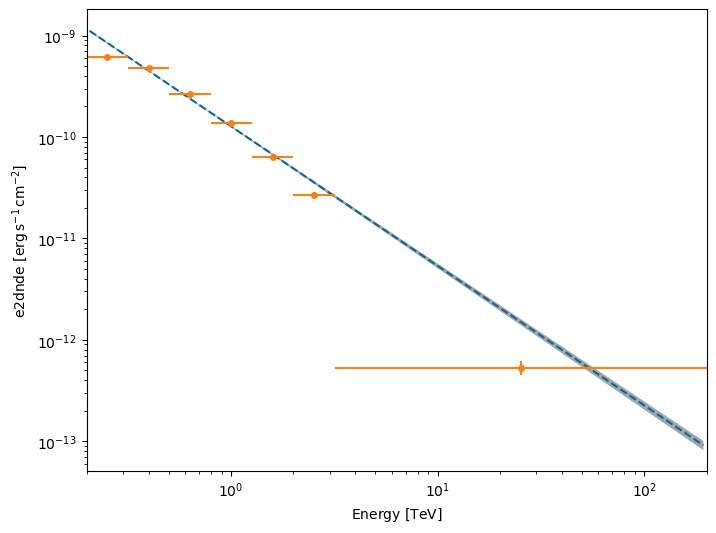

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_kwargs = {
    "energy_bounds": [e_min, e_max],
    "sed_type": "e2dnde",
    "yunits": u.Unit("erg cm-2 s-1"),
    "ax": ax,
}

# plot joint model
model_best_joint.spectral_model.plot(
    **plot_kwargs, ls="--"
)
model_best_joint.spectral_model.plot_error(facecolor="grey", alpha=0.7, **plot_kwargs)

flux_points.plot(ax=plot_kwargs["ax"],
                 sed_type=plot_kwargs["sed_type"],
                 )

# Light curve

Let's compute the light curve in two energy ranges

In [ ]:
energy_lo = [e_min.value, e_split.value] * e_min.unit
energy_hi = [e_split.value, e_max.value] * e_max.unit
energy_all = [e_min.value, e_max.value] * e_min.unit

e_ranges = [energy_lo, energy_hi, energy_all]

In [ ]:
lc_maker = LightCurveEstimator(energy_edges=[e_min, e_split, e_max],
                               source=model_best_joint.name,
                               time_intervals=time_intervals,
                               selection_optional=["errn-errp", "ul", "scan"],
                               n_jobs=6,
                              )
lc = lc_maker.run(datasets)

In [ ]:
lc.plot(sed_type="flux", time_format="mjd", axis_name="time")

We can also rebin the light curve to larger, fixed time bins, or requesting a minimum TS:

In [ ]:
lc_maker_new = LightCurveEstimator(energy_edges=[e_min, e_max],
                                   source=model_best_joint.name,
                                   time_intervals=time_intervals,
                                   selection_optional="all",
                                   n_jobs=6,
                              )
lc_all = lc_maker_new.run(datasets)

In [ ]:
axis_new = get_rebinned_axis(lc_all, method="min-ts", ts_threshold=2500, axis_name="time")
# axis_new = get_rebinned_axis(lc_all, method="fixed-bins", group_size=3, axis_name="time")
print(axis_new)


lc_new = lc_all.resample_axis(axis_new)

plt.figure(figsize=(8, 6))
ax = lc_all.plot(label="original")
lc_new.plot(ax=ax, label="rebinned")
plt.legend()
plt.show()

# Fractional and point-to-point variability

In [ ]:
compute_lightcurve_fvar(lc, flux_quantity='flux').pprint_all()

In [ ]:
compute_lightcurve_fpp(lc, flux_quantity='flux').pprint_all()

In [ ]:
compute_lightcurve_doublingtime(lc, flux_quantity='flux').pprint_all()

# Hardness ratio diagrams

Let's compute the flux ratio of our two light curves, plot them against time, and against the overall flux (i.e. hardness ratio diagram).

Access the low-energy and high-energy light curves.

**Tip**: Remember that `RegionNDMap` holds quantities of `numpy.ndarray`s.

In [ ]:
lc_lo = lc.flux.quantity[:, [0]].flatten()
lc_lo_err = lc.flux_err.quantity[:, [0]].flatten()

lc_hi = lc.flux.quantity[:, [1]].flatten()
lc_hi_err = lc.flux_err.quantity[:, [1]].flatten()

lc_tot = lc_lo+lc_hi
lc_tot_err = np.sqrt(lc_hi_err**2 + lc_lo_err**2)

In [ ]:
flux_ratio = lc_hi/lc_lo

In [ ]:
flux_ratio_err = flux_ratio * np.sqrt((lc_hi_err/lc_hi)**2+(lc_lo_err/lc_lo)**2)

In [ ]:
t_mean = [0.5*(t[0].mjd+t[1].mjd) for t in time_intervals]

In [ ]:
plt.errorbar(x=t_mean, y=flux_ratio, yerr=flux_ratio_err, fmt='o')
plt.xlabel("Time (MJD)")
plt.ylabel(f"Hardness ratio ({e_ranges[1][0]:.1f}-{e_ranges[1][1]:.1f}/{e_ranges[0][0]:.1f}-{e_ranges[0][1]:.1f})")

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

t = ((t_mean-t_mean[0]) * u.d).to(u.h)

cmap_norm = matplotlib.colors.Normalize(vmin=min(t.value), vmax=max(t.value))
mapper = matplotlib.cm.ScalarMappable(norm=cmap_norm, cmap='cividis')
time_colors = np.array([(mapper.to_rgba(_)) for _ in t.value])

for _x, _y, _ex, _ey, _color in zip(flux_ratio, lc_tot, flux_ratio_err, lc_tot_err, time_colors):
    ax.plot(_x, _y, 'o', color=_color)
    ax.errorbar(x=_x,
                xerr=_ex,
                y=_y,
                yerr=_ey,
                color=_color,
               )
ax.set_xlabel(f"Hardness ratio ({e_ranges[1][0]:.1f}-{e_ranges[1][1]:.1f}/{e_ranges[0][0]:.1f}-{e_ranges[0][1]:.1f})")
ax.set_ylabel(f"Flux ({e_ranges[2][0]:.1f}-{e_ranges[2][1]:.1f})")
fig.colorbar(mapper, ax=ax, orientation='vertical', label="Time (h)")